**Мета:**

Ознайомлення з загальним принципами напівкерованого навчання. Отримання навичок роботи з маркованими і немаркованими наборами даних. Отримання навичок побудови напівкерованих моделей но основі нейроних мереж.


**Порядок виконання**

Короки позначені знаком [*] є не обовʼязковими для виконання і не впливають на оцінку за лабораторну роботу.

1) Встановити сід генератору псевдовипадкових чисел;

2) Завантажити обраний набір даних;

3) [*] Відобразити декілька зображень з набору даних у блокноті;

4) Розділити обраний набір даних на дві вибірки: тренувальну та валідаційну, співвідношення розміру вибірок обрати на власний розсуд. Після чого розділити тренувальний набір на дві частини марковану(30%) та немарковану(70%);

5) Завантажити та налаштувати нейронну мережу обраної архітектури;

6) Провести навчання нейронної мережі на початковому (до розділу на маркований і немаркований) тренувальному наборі даних. Вибір гіперпараметрів на власний розсуд. Побудувати графіки точності та loss мережі під час навчання;

7) Зберегти ваги навченої нейронної мережі у файл.

8) Провести навчання нейронної мережі напівкерованим алгоритмом використовуючи маркований і немаркований набір даних на 4 кроці. Вибір гіперпараметрів на власний розсуд. Побудувати графік точності моделі;

9) Зберегти ваги навченої нейронної мережі у файл.

10) Побудувати графіки точності та loss мережі під час навчання.

11) Зробити висновки, оформити звіт.


**Встановлення бібліотек**

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

**Встановлення сіда генератора псевдовипадкових чисел**

In [4]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

**Завантаження набору даних MNIST**

In [6]:
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train_full = x_train_full / 255.0
x_test = x_test / 255.0

print(f"Full training set shape: {x_train_full.shape}")
print(f"Full training set label shape: {y_train_full.shape}")
print(f"Test set shape: {x_test.shape}")
print(f"Test set label shape: {y_test.shape}")

Full training set shape: (60000, 28, 28)
Full training set label shape: (60000,)
Test set shape: (10000, 28, 28)
Test set label shape: (10000,)


**Відображення зображень**

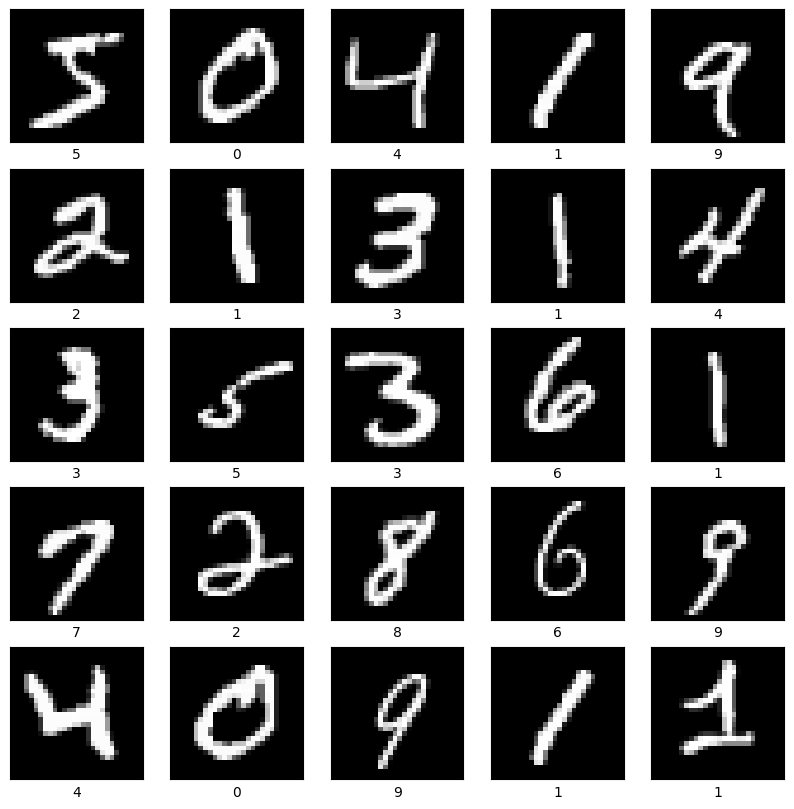

In [10]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train_full[i], cmap="gray")
    plt.xlabel(f"{y_train_full[i]}")
plt.show()


**Розділення набору даних**

In [13]:
from sklearn.model_selection import train_test_split

# Розділення на тренувальну і валідаційну вибірки
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_full, y_train_full, test_size=0.1, random_state=seed
)
print(f"Розмір тренувальної вибірки: {x_train.shape}")
print(f"Розмір валідаційної вибірки: {x_valid.shape}")

# Розділення тренувального набору на марковану і немарковану частини
x_train_labeled, x_train_unlabeled, y_train_labeled, _ = train_test_split(
    x_train, y_train, test_size=0.7, random_state=seed
)
print(f"Розмір маркованої тренувальної вибірки: {x_train_labeled.shape}")
print(f"Розмір немаркованої тренувальної вибірки: {x_train_unlabeled.shape}")


Розмір тренувальної вибірки: (54000, 28, 28)
Розмір валідаційної вибірки: (6000, 28, 28)
Розмір маркованої тренувальної вибірки: (16200, 28, 28)
Розмір немаркованої тренувальної вибірки: (37800, 28, 28)


**Підлаштовуємо дані під архітектуру обраної нейронної мережі**

In [14]:
# Зміна розміру зображень та додавання додаткового каналу кольору
x_train_labeled = np.expand_dims(x_train_labeled, axis=-1)
x_train_unlabeled = np.expand_dims(x_train_unlabeled, axis=-1)
x_valid = np.expand_dims(x_valid, axis=-1)

x_train_labeled = tf.image.resize(x_train_labeled, [32, 32])
x_train_unlabeled = tf.image.resize(x_train_unlabeled, [32, 32])
x_valid = tf.image.resize(x_valid, [32, 32])

x_train_labeled = np.repeat(x_train_labeled, 3, axis=-1)
x_train_unlabeled = np.repeat(x_train_unlabeled, 3, axis=-1)
x_valid = np.repeat(x_valid, 3, axis=-1)

print(f"Розмір маркованої тренувальної вибірки після зміни: {x_train_labeled.shape}")
print(f"Розмір немаркованої тренувальної вибірки після зміни: {x_train_unlabeled.shape}")
print(f"Розмір валідаційної вибірки після зміни: {x_valid.shape}")

Розмір маркованої тренувальної вибірки після зміни: (16200, 32, 32, 3)
Розмір немаркованої тренувальної вибірки після зміни: (37800, 32, 32, 3)
Розмір валідаційної вибірки після зміни: (6000, 32, 32, 3)


**Налаштування нейронної мережі**

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Створення моделі
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 4096)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

**Навчання моделі на маркованих даних**

In [18]:
history = model.fit(x_train_labeled, y_train_labeled, epochs=10,
                    validation_data=(x_valid, y_valid))

Epoch 1/10
507/507 [==============================] - 26s 52ms/step - loss: 0.0044 - accuracy: 0.9985 - val_loss: 0.0695 - val_accuracy: 0.9857
Epoch 2/10
507/507 [==============================] - 28s 55ms/step - loss: 0.0098 - accuracy: 0.9970 - val_loss: 0.0817 - val_accuracy: 0.9828
Epoch 3/10
507/507 [==============================] - 27s 53ms/step - loss: 0.0084 - accuracy: 0.9977 - val_loss: 0.1160 - val_accuracy: 0.9738
Epoch 4/10
507/507 [==============================] - 26s 51ms/step - loss: 0.0051 - accuracy: 0.9980 - val_loss: 0.0730 - val_accuracy: 0.9858
Epoch 5/10
507/507 [==============================] - 26s 52ms/step - loss: 0.0014 - accuracy: 0.9994 - val_loss: 0.0780 - val_accuracy: 0.9870
Epoch 6/10
507/507 [==============================] - 26s 52ms/step - loss: 0.0066 - accuracy: 0.9979 - val_loss: 0.1059 - val_accuracy: 0.9810
Epoch 7/10
507/507 [==============================] - 26s 52ms/step - loss: 0.0098 - accuracy: 0.9970 - val_loss: 0.0855 - val_accuracy:

**Збереження вагів моделі**

In [20]:
model.save_weights('model_weights_pretrained.h5')
from google.colab import files
files.download('model_weights_pretrained.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Проведення напівкерованого навчання з Proxy Labelling**

In [21]:
# Генерація псевдо-міток для немаркованих даних
pseudo_labels = model.predict(x_train_unlabeled)
pseudo_labels = np.argmax(pseudo_labels, axis=1)

# Об'єднання маркованих і немаркованих даних з їх відповідними мітками
x_combined = np.concatenate((x_train_labeled, x_train_unlabeled), axis=0)
y_combined = np.concatenate((y_train_labeled, pseudo_labels), axis=0)

# Навчання моделі на комбінованих даних
history_semi_supervised = model.fit(x_combined, y_combined, epochs=10,
                                    validation_data=(x_valid, y_valid))

1182/1182 [==============================] - 18s 16ms/step
Epoch 1/10
1688/1688 [==============================] - 83s 49ms/step - loss: 0.0277 - accuracy: 0.9907 - val_loss: 0.0540 - val_accuracy: 0.9858
Epoch 2/10
1688/1688 [==============================] - 85s 51ms/step - loss: 0.0143 - accuracy: 0.9950 - val_loss: 0.0669 - val_accuracy: 0.9840
Epoch 3/10
1688/1688 [==============================] - 82s 49ms/step - loss: 0.0110 - accuracy: 0.9963 - val_loss: 0.0666 - val_accuracy: 0.9863
Epoch 4/10
1688/1688 [==============================] - 82s 48ms/step - loss: 0.0090 - accuracy: 0.9971 - val_loss: 0.0671 - val_accuracy: 0.9855
Epoch 5/10
1688/1688 [==============================] - 80s 47ms/step - loss: 0.0086 - accuracy: 0.9970 - val_loss: 0.0766 - val_accuracy: 0.9855
Epoch 6/10
1688/1688 [==============================] - 82s 49ms/step - loss: 0.0067 - accuracy: 0.9975 - val_loss: 0.0768 - val_accuracy: 0.9873
Epoch 7/10
1688/1688 [==============================] - 84s 50ms/

**Збереження вагів моделі після напівкерованого навчання**

In [23]:
model.save_weights('model_weights_semi_supervised.h5')
files.download('model_weights_semi_supervised.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Візуалізація графіків точності та втрат**

> 1) Графіки для першого етапу навчання

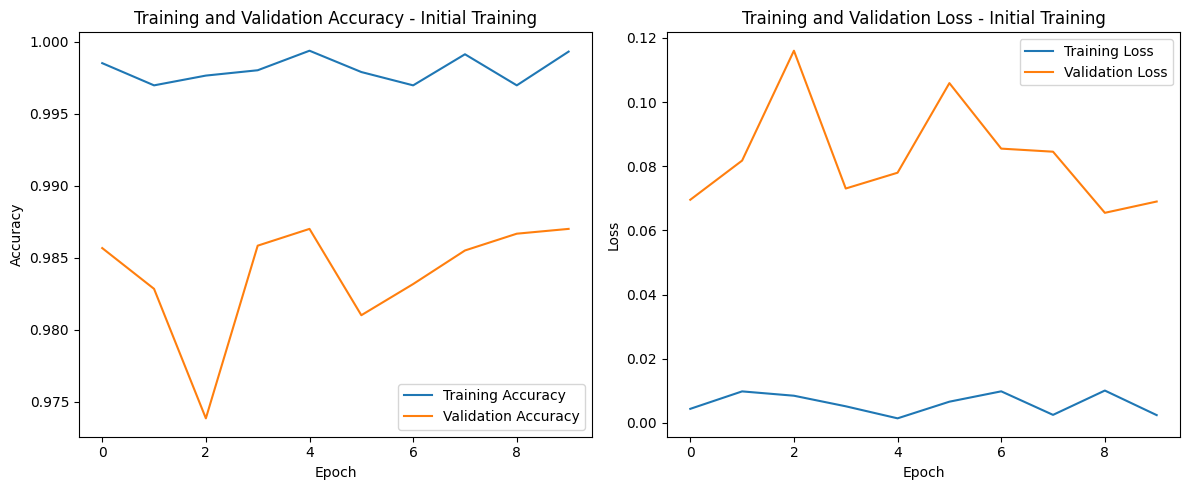

In [24]:
import matplotlib.pyplot as plt

# Графік точності для навчання на початковому тренувальному наборі
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy - Initial Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Графік втрат для навчання на початковому тренувальному наборі
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss - Initial Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()




> 2) Графіки для етапу напівкерованого навчання



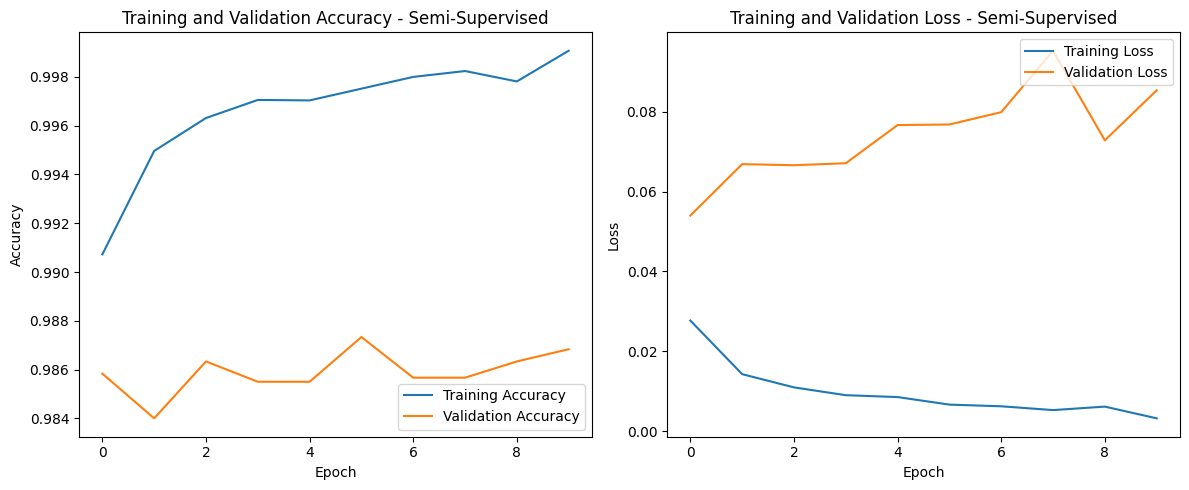

In [26]:
# Графік точності для напівкерованого навчання
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_semi_supervised.history['accuracy'], label='Training Accuracy')
plt.plot(history_semi_supervised.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy - Semi-Supervised')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Графік втрат для напівкерованого навчання
plt.subplot(1, 2, 2)
plt.plot(history_semi_supervised.history['loss'], label='Training Loss')
plt.plot(history_semi_supervised.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss - Semi-Supervised')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


**Висновок:**

Під час виконання лабараторної роботи була реалізовано модель повністю керованого навчання та напівкерованого навчання для набору данних MNIST. Результати навчань,а саме значення Accuracy та Loss, показані на графіках. Незважаючи на те що модель напівкерованого навчання не показала кращих результатів за модель повністю керованого навчання, оскільки результати і так були майже ідеальні, можна стверджувати що модель напівкерованого навчання добре справилась з завданням і якщо б не такий простий набір данних як MNIST то скоріш за все результати були б у неї кращі.